# What should I watch next?

Implementation of a movie recommendation system trained on the dataset [MovieLens25m](https://grouplens.org/datasets/movielens/25m/), which contains 25 million ratings applied to 62,000 movies by 162,000 users. The dataset also includes tag genome data with 15 million relevance scores across 1,129 tags, which we will not use in this project.

## Packages

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis and Preprocessing

In this section we want to get a feeling of the data and check if any data cleaning or preprocessing is required.
First, we load the data:

In [92]:
df_movies = pd.read_csv('data/movies.csv')
df_ratings = pd.read_csv('data/ratings.csv')

In [93]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [94]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Let us check if any missing value is present. 

In [95]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

No missing values found. We also check for the movie dataset, albeit not essential:

In [96]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Again, no missing values. 

Let us check that no duplicate ratings have been added by mistake:

In [97]:
df_movies.duplicated().sum()

0

We can proceed with the analysis.

We recall that ratings are essentially an (ordinal) categorical variable with the following distribution:

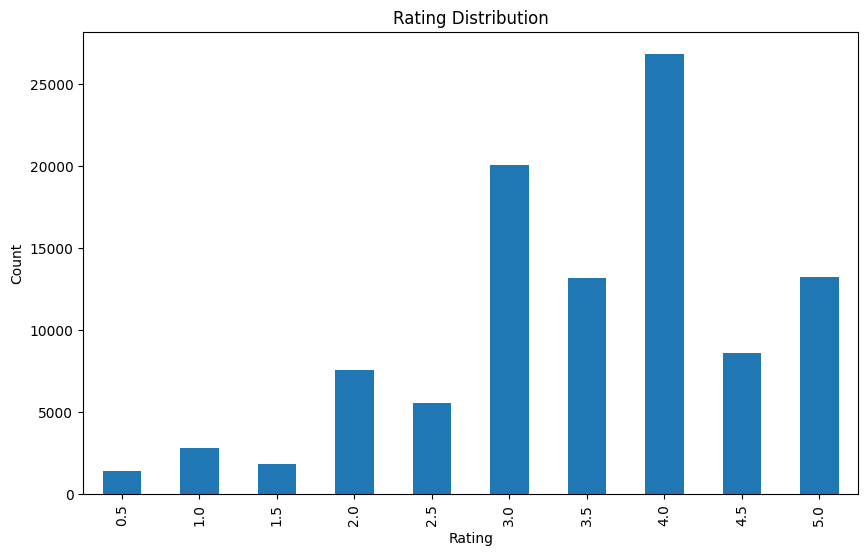

In [98]:
plt.figure(figsize=(10, 6))
df_ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

For the sake of the implementation of ALS no particular data cleaning procedure is needed: we will not need to handle genres (which would be necessary instead if we implemented a content based recommender) and we will not need metadata on movies and ratings. 

We will however need some of this information for building the "small" example we will use for visualizing the algorithm, as we will clarify later. Hence, we clean the genre column in the movie dataset:

In [99]:
df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies_ohe = df_movies.join(df_movies.pop('genres').str.join('|').str.get_dummies())
df_movies_ohe.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's have a look at the number of users and movies.

In [100]:
n_movies = df_movies_ohe.shape[0]
n_users = df_ratings['userId'].nunique()
print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')

Number of movies: 9742
Number of users: 610


Of course, it wouldn't make sense to get rid of certain users before applying our algorithms: we want to be able to make recommendations for all our users, and all of them have a non-negligible minimum amount of ratings anyway:

In [101]:
user_freq = df_ratings['userId'].value_counts()
user_freq = user_freq.sort_values(ascending=False)
user_freq.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64

On the contrary, we may look into the distribution of the ratings by movie:

In [102]:
movie_freq = df_ratings['movieId'].value_counts()
movie_freq = movie_freq.sort_values(ascending=False)
movie_freq.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count, dtype: float64

Notice the median number of ratings per movie: 3. 
It is true that we aim at making recommendations that do not suffer from a popularity bias (i.e. we want to avoid to recommend only popular movies to everyone), but to make things more manageable and provide meaningful recommendations we drop all movies with less than 3 reviews. After all, with thousands of possible movies to choose from we wouldn't want to rely on movies with only a handful of reviews. Also, popularity bias is a common problem of neighbourhood methods, but by design matrix factorization algorithms do not tend to suffer from it.

This choice clearly affects the likelihood of recommending movies that have been only recently added to our library, but we believe this instance should rather be handled separately with a recommender for a "what's new?" or a "trending now" section of our recommendation website or streaming service. For movies that have been for a long time on the platform but only have a handful reviews, we can safely assume that they are "niche" items, which are likely to be specifally searched for by the few interested users.

In [103]:
df_ratings.shape[0]

100836

In [104]:
min_movie_ratings = 6
filter_movies = movie_freq[movie_freq >= min_movie_ratings].index
df_ratings = df_ratings[df_ratings['movieId'].isin(filter_movies)]
df_ratings.shape[0]

88364

It's hardly noticeable in terms of total number of ratings of course, but it significanly lowers the movies dimension (making the user-item matrix belong to a much smaller space). To explicitly refer to the notation of the report of the project:
$$
R\in\mathbb{R}^{n\times m} \longrightarrow R\in\mathbb{R}^{n\times m'} \text{ where } m'\approx\frac{m}{2}
$$

For the user-item matrix, we can also get rid of the timestamp column (which indicates the time at which a rating was given).

In [105]:
df_ratings = df_ratings.drop('timestamp', axis=1)

Let us now create the user-item matrix by pivoting the current dataframe of ratings.

In [106]:
user_item_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating', )
user_item_matrix.fillna(0, inplace=True)
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,174055,175303,176101,176371,177593,177765,179401,179819,180031,187593
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Despite the fact that the sparsity effect has been mitigated by our filtering on "niche" movies, it is indeed a sparse matrix:

In [107]:
p = df_ratings.shape[0] / (user_item_matrix.shape[0] * user_item_matrix.shape[1])
print("Proportion of matrix filled:", p)

Proportion of matrix filled: 0.04432650440435821


No we plot the drastic decrease in the magnitude of the singular values, supporting our case for a latent space of lower dimension that can grasp and explain most of the variability of the data.

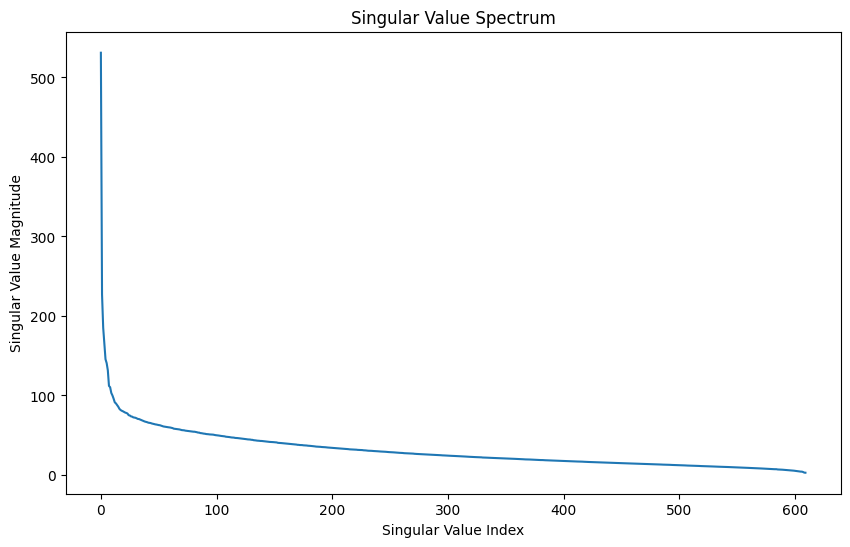

In [108]:
# plot on the magnitude of the singular values of the user-item matrix compared to their number (eg.: magnitude of the first singular value, magnitude of the second singular value, etc.)

U, s, Vt = np.linalg.svd(user_item_matrix, full_matrices=False)

plt.figure(figsize=(10, 6))
plt.plot(s)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.title('Singular Value Spectrum')
plt.show()

# A "Toy" Example

We have discussed in the report that the latent factors built by ALS essentially represent more or less interpretable and complicated movie features and the way each user may or may not appreciate them.

To clarify this heuristic, we choose a (very) small subset of movies and users as follows.

We focus on choosing movies that highlight two easily interpretable factors. One would be the level of action in the movie, and the other that 

In [109]:
# select the most rated movies
n = 8
# compute number of ratings per movie and sort movies accordingly
movie_freq = df_ratings['movieId'].value_counts()
movie_freq = movie_freq.sort_values(ascending=False)
# select the most rated movies
top_movies = movie_freq.head(n).index
# get movie titles
top_movie_titles = df_movies[df_movies['movieId'].isin(top_movies)]['title']
top_movie_titles

97                              Braveheart (1995)
224     Star Wars: Episode IV - A New Hope (1977)
257                           Pulp Fiction (1994)
277              Shawshank Redemption, The (1994)
314                           Forrest Gump (1994)
418                          Jurassic Park (1993)
510              Silence of the Lambs, The (1991)
1939                           Matrix, The (1999)
Name: title, dtype: object

In [110]:
user_list = []
# select users who rated all top_movies
mask = df_ratings['movieId'].isin(top_movies)
top_users = df_ratings[mask]['userId'].value_counts()
top_users = top_users[top_users == n].index
# get user ids
top_users

# select users who rated all top movies but one
but_one_users = df_ratings[mask]['userId'].value_counts()
but_one_users = but_one_users[but_one_users == n - 1].index
# get user ids
but_one_users
# pick one at random to remember
user_list.append(but_one_users[np.random.choice(but_one_users.shape[0])])
user_list.append(but_one_users[np.random.choice(but_one_users.shape[0])])

# amongst the first, choose the one with the highest average rating
avg_ratings = df_ratings[df_ratings['userId'].isin(top_users)].groupby('userId')['rating'].mean()
best_user = avg_ratings.idxmax()
# get user id
best_user
user_list.append(best_user)
# get ratings
df_ratings[(df_ratings['userId'] == best_user) & mask]

# find the two users with the lowest average ratings
worst_users = avg_ratings.nsmallest(2).index
worst_users
user_list.append(worst_users[0])
user_list.append(worst_users[1])

# get ratings
df_ratings[df_ratings['userId'].isin(worst_users) & mask]

# finally pick the user with the lowest score in movieId 314
worst_movie = 314
worst_movie_ratings = df_ratings[df_ratings['movieId'] == worst_movie].groupby('userId')['rating'].mean()
worst_user = worst_movie_ratings.idxmin()
worst_user
user_list.append(worst_user)

# and the one with lowest in movieId 224
worst_movie = 224
worst_movie_ratings = df_ratings[df_ratings['movieId'] == worst_movie].groupby('userId')['rating'].mean()
worst_user = worst_movie_ratings.idxmin()
worst_user
user_list.append(worst_user)

user_list


[42, 141, 573, 599, 307, 488, 411]

In [111]:
# filter ratings based on the user_list and top_movies lists
filtered_ratings = df_ratings[(df_ratings['userId'].isin(user_list)) & (df_ratings['movieId'].isin(top_movies))]

# store in data/toy_example_ratings.csv
filtered_ratings.to_csv("data/toy_example.csv")


# ALS-WR implementation

In [216]:
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import find

class UserItemMatrix():
    def __init__(self, ratings_path, movie_path, sparse = True):
        self.sparse = sparse
        self.ratings_path = ratings_path
        self.movie_path = movie_path
        if sparse:
            # we use csr
            self._create_sparse_user_item_matrix(ratings_path)
            self.shape = self.user_item_matrix_csr.shape
        else:
            self._create_dense_user_item_matrix(ratings_path)
            self.shape = self.user_item_matrix.shape
        # lookup tables for idx's vs id's are needed in the sparse case
        self._create_movie_table(movie_path, ratings_path)
        self._create_user_table(ratings_path)

    def _create_dense_user_item_matrix(self, ratings_path):
        df_ratings = pd.read_csv(ratings_path)
        # check that userId, movieId and rating columns are present in df_ratings
        if not all(col in df_ratings.columns for col in ["userId", "movieId", "rating"]):
            raise ValueError("userId, movieId, and rating columns are required in df_ratings.")
        # check that userId and movieId are unique
        if not df_ratings[['userId', 'movieId']].duplicated().sum() == 0:
            raise ValueError("userId and movieId should be unique.")
        # create user item matrix
        self.user_item_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating')
        # fill missing values with 0
        self.user_item_matrix.fillna(0, inplace=True)
        # store only values
        self.user_item_matrix = self.user_item_matrix.values
        return

    def _create_sparse_user_item_matrix(self, ratings_path):
        df_ratings = pd.read_csv(ratings_path)
        # check that userId, movieId and rating columns are present in df_ratings
        if not all(col in df_ratings.columns for col in ["userId", "movieId", "rating"]):
            raise ValueError("userId, movieId, and rating columns are required in df_ratings.")
        # check that userId and movieId are unique
        if not df_ratings[['userId', 'movieId']].duplicated().sum() == 0:
            raise ValueError("userId and movieId should be unique.")
        # create user item matrix, but first we need to reset the index
        # substitute userId and movieId with new indexes
        df_ratings['userId'] = df_ratings['userId'].astype('category').cat.codes
        df_ratings['movieId'] = df_ratings['movieId'].astype('category').cat.codes
        self.user_item_matrix_csr = csr_matrix((df_ratings['rating'], (df_ratings['userId'], df_ratings['movieId'])))
        self.user_item_matrix_csc = self.user_item_matrix_csr.tocsc()
        return
    
    def _create_movie_table(self, movie_path, ratings_path):
        df_movies = pd.read_csv(movie_path)
        df_ratings = pd.read_csv(ratings_path)
        # check that movieId and title columns are present in df_movies
        if not all(col in df_movies.columns for col in ["movieId", "title"]):
            raise ValueError("movieId and title columns are required in df_movies.")
        # store an array with numerical index, movieId and title
        self.movie_table = df_movies[['movieId', 'title']]
        # subset for movies in ratings
        self.movie_table = self.movie_table[self.movie_table['movieId'].isin(df_ratings['movieId'].unique())]
        # reset indices
        self.movie_table.reset_index(inplace=True)
        return
    
    def _create_user_table(self, ratings_path):
        df_ratings = pd.read_csv(ratings_path)
        self.user_table = df_ratings[['userId']].drop_duplicates().reset_index(drop=True)
        return
    
    def shape(self):
        if self.sparse:
            return self._get_sparse_shape()
        else:
            return self._get_dense_shape()
        
    def _get_dense_shape(self):
        return self.user_item_matrix.shape
    
    def _get_sparse_shape(self):
        return self.user_item_matrix_csr.shape
    
    def get_movie_id(self, movie_idx):
        return self.movie_table.iloc[movie_idx]['movieId']
        
    def get_movie_idx(self, movie_id):
        return self.movie_table[self.movie_table['movieId'] == movie_id].index[0]
        
    def get_movie_name(self, movie_id, from_idx = False):
        if from_idx:
            return self.movie_table["title"][movie_id]
        else:
            return self.movie_table[self.movie_table['movieId'] == movie_id]['title'].values[0]

    def get_user_id(self, user_idx):
        return self.user_table.iloc[user_idx]['userId']
    
    def get_user_idx(self, user_id):
        return self.user_table[self.user_table['userId'] == user_id].index[0]
    
    def user_ratings(self, user_id, nnz=True):
        if self.sparse:
            user_idx = self.get_user_idx(user_id)
            if nnz:
                # return only non zero ratings
                _, _, ratings = find(self.user_item_matrix_csr[user_idx])
                return ratings
            else:
                return self.user_item_matrix_csr[user_idx].toarray().reshape(-1)
        else:
            user_idx = self.get_user_idx(user_id)
            if nnz:
                return self.user_item_matrix[user_idx][self.user_item_matrix[user_idx] > 0]
            else:
                return self.user_item_matrix[user_idx]
        
    def movie_ratings(self, movie_id, nnz=True):
        movie_idx = self.get_movie_idx(movie_id)
        if self.sparse:
            if nnz:
                # return only non zero ratings
                _, _, ratings = find(self.user_item_matrix_csc[:, movie_idx])
                return ratings
            else:
                return self.user_item_matrix_csc[:, movie_idx].toarray().reshape(-1)
        else:
            if nnz:
                return self.user_item_matrix[self.user_item_matrix[:, movie_idx] > 0, movie_idx]
            else:
                return self.user_item_matrix[:, movie_idx]
        
    def get_user_table(self):
        return self.user_table
    
    def get_movie_table(self):
        return self.movie_table
    
    def get_user_item_matrix(self):
        # return dataframe
        if self.sparse:
            uim = pd.DataFrame(self.user_item_matrix_csr.todense())
        else:
            uim = pd.DataFrame(self.user_item_matrix)
        # switch rows index to userId
        uim.index = self.user_table['userId']
        # switch columns index to movieId
        uim.columns = self.movie_table['movieId']
        return uim
    
    def nnz_count(self):
        if self.sparse:
            return self._sparse_nnz_count()
        else:
            return self._dense_nnz_count()

    def _dense_nnz_count(self):
        return np.count_nonzero(self.user_item_matrix)

    def _sparse_nnz_count(self):
        return self.user_item_matrix_csr.nnz
    
    def nnz_by_user(self, user_id=None):
        if self.sparse:
            return self._sparse_nnz_by_user(user_id)
        else:
            return self._dense_nnz_by_user(user_id)
        
    def _dense_nnz_by_user(self, user_id=None):
        if user_id is None:
            return np.count_nonzero(self.user_item_matrix, axis=1)
        else:
            user_idx = self.get_user_idx(user_id)
            return np.count_nonzero(self.user_item_matrix[user_idx])
        
    def _sparse_nnz_by_user(self, user_id=None):
        if user_id is None:
            return self.user_item_matrix_csr.getnnz(axis=1)
        else:
            user_idx = self.get_user_idx(user_id)
            return self.user_item_matrix_csr[user_idx].getnnz()
    
    def nnz_by_movie(self, movie_id=None):
        if self.sparse:
            return self._sparse_nnz_by_movie(movie_id)
        else:
            return self._dense_nnz_by_movie(movie_id)
        
    def _dense_nnz_by_movie(self, movie_id=None):
        if movie_id is None:
            return np.count_nonzero(self.user_item_matrix, axis=0)
        else:
            movie_idx = self.get_movie_idx(movie_id)
            return np.count_nonzero(self.user_item_matrix[:, movie_idx])
    
    def _sparse_nnz_by_movie(self, movie_id=None):
        if movie_id is None:
            return self.user_item_matrix_csc.getnnz(axis=0)
        else:
            movie_idx = self.get_movie_idx(movie_id)
            return self.user_item_matrix_csc[:, movie_idx].getnnz()
        
    def mean_of_ratings(self, axis=None):
        if self.sparse:
            return self._sparse_mean_of_ratings(axis)
        else:
            return self._dense_mean_of_ratings(axis)
        
    def _dense_mean_of_ratings(self, axis):
        if axis is None:
            return np.mean(self.user_item_matrix[self.user_item_matrix != 0])
        else:
            return np.mean(self.user_item_matrix, axis=axis)
    
    def _sparse_mean_of_ratings(self, axis):
        if axis is None:
            return self.user_item_matrix_csr.sum() / self.user_item_matrix_csr.nnz
        else:
            if axis == 0:
                tmp = self.user_item_matrix_csc.mean(axis=axis) 
                return np.array(tmp).reshape(-1)
            elif axis == 1:
                tmp = self.user_item_matrix_csr.mean(axis=axis) 
                return np.array(tmp).reshape(-1)
            else:
                raise ValueError("axis should be 0, 1 or None")

    def where_nnz_user(self, user_id):
        if self.sparse:
            return self._sparse_where_nnz_user(user_id)
        else:
            return self._dense_where_nnz_user(user_id)
        
    def _dense_where_nnz_user(self, user_id):
        user_idx = self.get_user_idx(user_id)
        return self.user_item_matrix[user_idx].nonzero()[0]
    
    def _sparse_where_nnz_user(self, user_id):
        user_idx = self.get_user_idx(user_id)
        return self.user_item_matrix_csr[user_idx].indices
    
    def where_nnz_movie(self, movie_id):
        if self.sparse:
            return self._sparse_where_nnz_movie(movie_id)
        else:
            return self._dense_where_nnz_movie(movie_id)
        
    def _dense_where_nnz_movie(self, movie_id):
        movie_idx = self.get_movie_idx(movie_id)
        return self.user_item_matrix[:, movie_idx].nonzero()[0]
    
    def _sparse_where_nnz_movie(self, movie_id):
        movie_idx = self.get_movie_idx(movie_id)
        return self.user_item_matrix_csc[:, movie_idx].indices
    
    def get_rating_path(self):
        return self.ratings_path
    
    def get_movie_path(self):
        return self.movie_path
    


In [113]:
# import numpy as np

# # Paths to the data files
# ratings_path = "data/toy_example.csv"
# movie_path = "data/movies.csv"

# # check users in the toy example
# df_ratings = pd.read_csv(ratings_path)
# df_ratings['userId'].unique()
# print(df_ratings['userId'].unique())

# # Initialize both sparse and dense UserItemMatrix instances
# uim_sparse = UserItemMatrix(ratings_path, movie_path, sparse=True)
# uim_dense = UserItemMatrix(ratings_path, movie_path, sparse=False)

# # Test shape method
# print("Sparse Shape:", uim_sparse.shape)
# print("Dense Shape:", uim_dense.shape)

# # Test get_movie_idx method
# movie_id_example = 110  # Assuming movieId 1 exists
# print("Movie Index (Sparse):", uim_sparse.get_movie_idx(movie_id_example))
# print("Movie Index (Dense):", uim_dense.get_movie_idx(movie_id_example))

# # Test get_movie_name method
# print("Movie Name by ID (Sparse):", uim_sparse.get_movie_name(movie_id_example, from_idx=False))
# print("Movie Name by ID (Dense):", uim_dense.get_movie_name(movie_id_example, from_idx=False))

# # Test get_movie_name method from id
# movie_idx_example = 0  # Assuming movie index 0 exists
# print("Movie Name by Index (Sparse):", uim_sparse.get_movie_name(movie_idx_example, from_idx=True))
# print("Movie Name by Index (Dense):", uim_dense.get_movie_name(movie_idx_example, from_idx=True))

# # Test get_user_id method
# user_idx_example = 0  # Assuming user index 0 exists
# print("User ID by Index (Sparse):", uim_sparse.get_user_id(user_idx_example))
# print("User ID by Index (Dense):", uim_dense.get_user_id(user_idx_example))

# # Test get_user_idx method
# user_id_example = 411
# print("User Index by ID (Sparse):", uim_sparse.get_user_idx(user_id_example))
# print("User Index by ID (Dense):", uim_dense.get_user_idx(user_id_example))

# # Test user_ratings method
# print("User Ratings (Sparse):", uim_sparse.user_ratings(user_id_example))
# print("User Ratings (Dense):", uim_dense.user_ratings(user_id_example))

# # Test movie_ratings method
# print("Movie Ratings (Sparse):", uim_sparse.movie_ratings(movie_id_example))
# print("Movie Ratings (Dense):", uim_dense.movie_ratings(movie_id_example))

# # Test get_user_table method
# print("User Table (Sparse):\n", uim_sparse.get_user_table().head())
# print("User Table (Dense):\n", uim_dense.get_user_table().head())

# # Test get_movie_table method
# print("Movie Table (Sparse):\n", uim_sparse.get_movie_table().head())
# print("Movie Table (Dense):\n", uim_dense.get_movie_table().head())

# # Test get_user_item_matrix method
# print("User Item Matrix (Sparse):\n", uim_sparse.get_user_item_matrix().head())
# print("User Item Matrix (Dense):\n", uim_dense.get_user_item_matrix().head())

# # Test nnz_count method
# print("Non-zero Count (Sparse):", uim_sparse.nnz_count())
# print("Non-zero Count (Dense):", uim_dense.nnz_count())

# # Test nnz_by_user method
# print("Non-zero by User (Sparse):", uim_sparse.nnz_by_user(user_id_example))
# print("Non-zero by User (Dense):", uim_dense.nnz_by_user(user_id_example))

# # Test nnz_by_movie method
# print("Non-zero by Movie (Sparse):", uim_sparse.nnz_by_movie(movie_id_example))
# print("Non-zero by Movie (Dense):", uim_dense.nnz_by_movie(movie_id_example))

# # Test mean_of_ratings method
# print("Mean of Ratings (Sparse):", uim_sparse.mean_of_ratings())
# print("Mean of Ratings (Dense):", uim_dense.mean_of_ratings())

# # Test mean_of_ratings method
# print("Mean of Ratings (Sparse):", uim_sparse.mean_of_ratings(axis=0))
# print("Mean of Ratings (Dense):", uim_dense.mean_of_ratings(axis=0))

# # Test mean_of_ratings method
# print("Mean of Ratings (Sparse):", uim_sparse.mean_of_ratings(axis=1))
# print("Mean of Ratings (Dense):", uim_dense.mean_of_ratings(axis=1))

# # Test where_nnz_user method
# print("Where Non-zero User (Sparse):", uim_sparse.where_nnz_user(user_id_example))
# print("Where Non-zero User (Dense):", uim_dense.where_nnz_user(user_id_example))

# # Test where_nnz_movie method
# print("Where Non-zero Movie (Sparse):", uim_sparse.where_nnz_movie(movie_id_example))
# print("Where Non-zero Movie (Dense):", uim_dense.where_nnz_movie(movie_id_example))

In [114]:
# from pympler import asizeof

# # paths
# ratings_path = "data/ratings.csv"
# movie_path = "data/movies.csv"

# # Initialize both sparse and dense UserItemMatrix instances
# uim_sparse = UserItemMatrix(ratings_path, movie_path, sparse=True)
# uim_dense = UserItemMatrix(ratings_path, movie_path, sparse=False)

# # Compute occupied space using pympler
# sparse_storage_total = asizeof.asizeof(uim_sparse)
# dense_storage_total = asizeof.asizeof(uim_dense)

# # Print occupied space
# print(f"Sparse UserItemMatrix total storage: {sparse_storage_total} bytes")
# print(f"Dense UserItemMatrix total storage: {dense_storage_total} bytes")


In [217]:
import numpy as np

class ALS_WR():
    def __init__(self, user_item_matrix, factor_dim = 100, seed=42):
        # check is instance of UserItemMatrix class
        if not isinstance(user_item_matrix, UserItemMatrix):
            raise ValueError("Constructor requires a UserItemMatrix object.")
        
        self.user_item_matrix = user_item_matrix
        self.n_ratings = self.user_item_matrix.nnz_count()
        self.n_users = self.user_item_matrix.shape[0]
        self.n_movies = self.user_item_matrix.shape[1]
        self.n_factors = factor_dim

        np.random.seed(seed)
    
    def fit(self, n_iter = 10, reg_param=0.1, regularization = "weighted", validation_path = None, patience = 2):
        
        self.reg_param = reg_param
        self.n_iter = n_iter 
        self.validation_path = validation_path
        self.patience = patience
        self.patience_counter = 0

        self._init_regularization(regularization)
        self._init_latent_factors()
        self._train()

    def _train(self):
        self.training_loss = []
        if self.validation_path is not None:
            self.validation_loss = []
            self._load_validation_data()
        else:
            self.validation_loss = None

        for i in range(self.n_iter):
            self._update_user_factors()
            self._update_movie_factors()
            self._compute_loss()
            if self.validation_path is not None:
                self._compute_validation_loss()
                if self._early_stopping(i):
                    break
        return
    
    def _load_validation_data(self):
        self.validation_user_item_matrix = UserItemMatrix(
            self.validation_path, self.user_item_matrix.get_movie_path(), sparse=True
            )
        return
    
    def _compute_validation_loss(self):
        loss = 0
        for i in range(self.validation_user_item_matrix.shape[0]):
            idx = self.validation_user_item_matrix.where_nnz_user(self.validation_user_item_matrix.get_user_id(i))
            V = self.movie_factors[:, idx]
            r = self.validation_user_item_matrix.user_ratings(self.validation_user_item_matrix.get_user_id(i))
            loss += np.sum((r - self.user_factors[i] @ V) ** 2)
        loss = loss / self.validation_user_item_matrix.nnz_count()
        loss = np.sqrt(loss)
        self.validation_loss.append(loss)
        # # regularization
        # RU = np.linalg.norm(self.reg_matrix_user @ self.user_factors, ord='fro') ** 2
        # RI = np.linalg.norm(self.movie_factors @ self.reg_matrix_item, ord='fro') ** 2
        # loss += self.reg_param * (RU + RI)
        # self.validation_loss.append(loss)
        return
    
    def _early_stopping(self, i):
        if i == 0:
            self.best_loss = self.validation_loss[i]
        else:
            if self.validation_loss[i] < self.best_loss:
                self.best_loss = self.validation_loss[i]
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter == self.patience:
                    return True
        return False

    def _update_user_factors(self):
        # update user factors
        for i in range(self.n_users):
            # get indices of non-zero ratings
            idx = self.user_item_matrix.where_nnz_user(self.user_item_matrix.get_user_id(i))
            # get movie factors
            V = self.movie_factors[:, idx]
            # get ratings
            r = self.user_item_matrix.user_ratings(self.user_item_matrix.get_user_id(i))
            # update user factors
            reg_i = self.reg_matrix_user[i,i]
            self.user_factors[i] = np.linalg.solve(V @ V.T + self.reg_param * reg_i, V @ r)
        return
    
    def _update_movie_factors(self):
        # update movie factors
        for j in range(self.n_movies):
            # get indices of non-zero ratings
            idx = self.user_item_matrix.where_nnz_movie(self.user_item_matrix.get_movie_id(j))
            # get user factors
            U = self.user_factors[idx]
            # get ratings
            r = self.user_item_matrix.movie_ratings(self.user_item_matrix.get_movie_id(j))
            # update movie factors
            reg_j = self.reg_matrix_item[j,j]
            self.movie_factors[:, j] = np.linalg.solve(U.T @ U + self.reg_param * reg_j, U.T @ r)
        return
    
    def _compute_loss(self):
        # compute loss
        loss = 0
        for i in range(self.n_users):
            idx = self.user_item_matrix.where_nnz_user(self.user_item_matrix.get_user_id(i))
            V = self.movie_factors[:, idx]
            r = self.user_item_matrix.user_ratings(self.user_item_matrix.get_user_id(i))
            loss += np.sum((r - self.user_factors[i] @ V) ** 2)

        loss = loss / self.n_ratings
        loss = np.sqrt(loss) #empirical RMSE is computed

        self.training_loss.append(loss)

        # add regularization term
        # RU = np.linalg.norm(self.reg_matrix_user @ self.user_factors, ord='fro') ** 2 
        # RI = np.linalg.norm(self.movie_factors @ self.reg_matrix_item, ord='fro') ** 2
        # loss += self.reg_param * (RU + RI)
        # self.training_loss.append(loss)
        return

    def _init_latent_factors(self):
        # initialize user and movie latent factors
        self.user_factors = np.random.rand(self.n_users, self.n_factors)
        self.movie_factors = np.random.rand(self.n_factors, self.n_movies)
        # use average ratings in the first column
        self.movie_factors[0, :] = self.user_item_matrix.mean_of_ratings(axis=0)
        return

    def _init_regularization(self, regularization):
        if regularization == "weighted":
            # compute vector of number of ratings per user
            n_ratings_user = self.user_item_matrix.nnz_by_user()
            self.reg_matrix_user = np.diag(np.sqrt(n_ratings_user))
            # compute vector of number of ratings per movie
            n_ratings_movie = self.user_item_matrix.nnz_by_movie()
            self.reg_matrix_item = np.diag(np.sqrt(n_ratings_movie))
        elif regularization == "l2":
            self.reg_matrix_user = np.eye(self.n_users)
            self.reg_matrix_item = np.eye(self.n_movies)
        else:
            raise ValueError("Regularization must be either 'weighted' or 'l2'.")
        return
    
    def get_factors(self):
        return self.user_factors, self.movie_factors
    
    def get_loss(self):
        return self.training_loss
    
    def get_validation_loss(self):
        return self.validation_loss
    
    def get_best_loss(self):
        return self.best_loss
    
    def predict_rating(self, user_id, movie_id):
        user_idx = self.user_item_matrix.get_user_idx(user_id)
        movie_idx = self.user_item_matrix.get_movie_idx(movie_id)
        # difference between the global mean and the estimated one
        global_mean = self.user_item_matrix.mean_of_ratings()
        # compute the estimated rating matrix
        R_hat = self.user_factors[user_idx] @ self.movie_factors[:, movie_idx]
        # compute the mean of R_hat
        R_hat_mean = R_hat.mean()
        # compute the estimated rating
        return self.user_factors[user_idx] @ self.movie_factors[:, movie_idx] + global_mean - R_hat_mean
    
    def recommend(self, user_id, n=10, include_seen=False):
        user_idx = self.user_item_matrix.get_user_idx(user_id)
        ratings = self.user_factors[user_idx] @ self.movie_factors
        if include_seen:
            top_n = ratings.argsort()[-n:][::-1]
        else:
            idx = self.user_item_matrix.where_nnz_user(user_id)
            ratings[idx] = 0
            top_n = ratings.argsort()[-n:][::-1]
        # print top n movie names
        for i in range(len(top_n)):
            print(f"Recommended {i+1}: {self.user_item_matrix.get_movie_name(top_n[i], from_idx=True)}")
        
        # return top n movie ids, not idxs
        return self.user_item_matrix.get_movie_id(top_n).values
    
                  

In [218]:
# test this ALS_WR class on the toy example
# paths
ratings_path = "data/toy_example.csv"
movie_path = "data/movies.csv"

uim_sparse = UserItemMatrix(ratings_path, movie_path, sparse=True)

# first, no validation
als = ALS_WR(uim_sparse, factor_dim=2)
als.fit(n_iter=10, reg_param=0.1, regularization="weighted")
# get 2 recommendations for the first user in the user list
user_id = uim_sparse.get_user_id(0)
# als.recommend(user_id, n=2, include_seen=False)
als.recommend(user_id, n=2, include_seen=True)

Recommended 1: Pulp Fiction (1994)
Recommended 2: Star Wars: Episode IV - A New Hope (1977)


array([296, 260], dtype=int64)

In [219]:
# load ratings toy
ratings_path = "data/toy_example.csv"
movie_path = "data/movies.csv"

# now we pick two ratings from 2 random users and 2 random movies they rated, to put in validation
df_ratings = pd.read_csv(ratings_path)

# get user ids
user_ids = df_ratings['userId'].unique()

# get two random user ids
np.random.seed(42)
np.random.shuffle(user_ids)
user_id_1 = user_ids[0]
user_id_2 = user_ids[1]

# get two random ratings from these users
ratings_user_1 = df_ratings[df_ratings['userId'] == user_id_1]
ratings_user_2 = df_ratings[df_ratings['userId'] == user_id_2]

movie_id_1 = ratings_user_1['movieId'].values[0]
movie_id_2 = ratings_user_2['movieId'].values[1]

# split df_ratings into training and validation
df_validation = df_ratings[(df_ratings['userId'].isin([user_id_1, user_id_2])) & (df_ratings['movieId'].isin([movie_id_1, movie_id_2]))]
df_ratings = df_ratings.drop(df_validation.index)


# store in data/toy_example_training.csv and data/toy_example_validation.csv
df_ratings.to_csv("data/toy_example_training.csv", index=False)
df_validation.to_csv("data/toy_example_validation.csv", index=False)

# now, with validation
uim_sparse = UserItemMatrix("data/toy_example_training.csv", movie_path, sparse=True)
als = ALS_WR(uim_sparse, factor_dim=2)
als.fit(n_iter=10, reg_param=0.1, regularization="weighted", validation_path="data/toy_example_validation.csv")
# get 2 recommendations for the first user in the user list
user_id = uim_sparse.get_user_id(0)
als.recommend(user_id, n=2, include_seen=True)


Recommended 1: Pulp Fiction (1994)
Recommended 2: Matrix, The (1999)


array([ 296, 2571], dtype=int64)

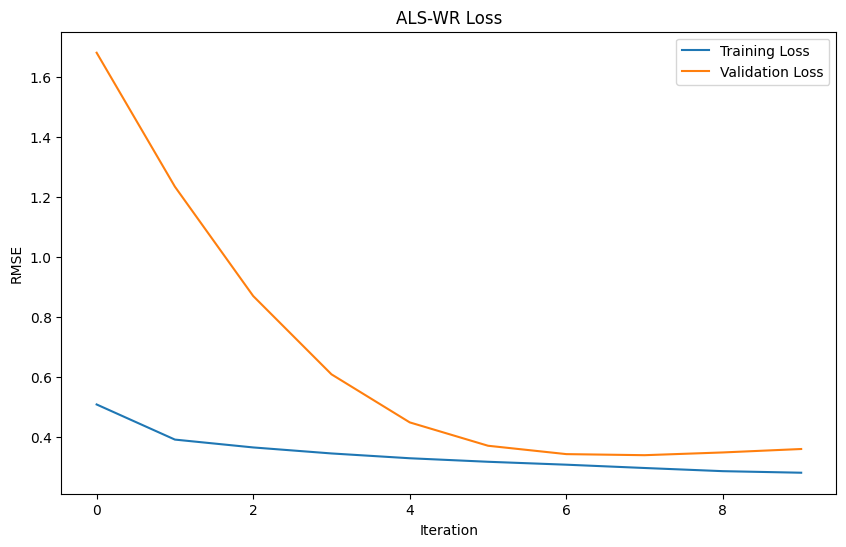

In [221]:
# plot validation and train losses
plt.figure(figsize=(10, 6))
plt.plot(als.get_loss(), label="Training Loss")
plt.plot(als.get_validation_loss(), label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("ALS-WR Loss")
plt.legend()
plt.show()

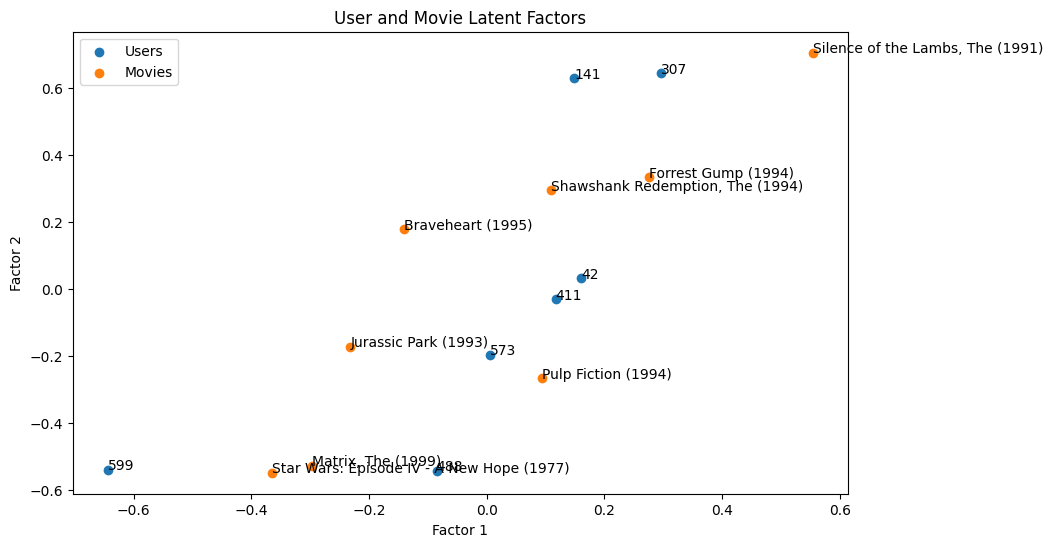

In [224]:
# plot in a bidimensional plane the latent factors of the users and the movies
user_factors, movie_factors = als.get_factors()
# center them
user_factors = user_factors - user_factors.mean(axis=0)
movie_factors = movie_factors - movie_factors.mean(axis=1).reshape(-1, 1)
plt.figure(figsize=(10, 6))
plt.scatter(user_factors[:, 0], user_factors[:, 1], label="Users")
plt.scatter(movie_factors[0, :], movie_factors[1, :], label="Movies")
# add to each movie the name
for i in range(movie_factors.shape[1]):
    plt.text(movie_factors[0, i], movie_factors[1, i], uim_sparse.get_movie_name(uim_sparse.get_movie_id(i), from_idx=False))
# add to each user the id
for i in range(user_factors.shape[0]):
    plt.text(user_factors[i, 0], user_factors[i, 1], uim_sparse.get_user_id(i))
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.title("User and Movie Latent Factors")
plt.legend()
plt.show()

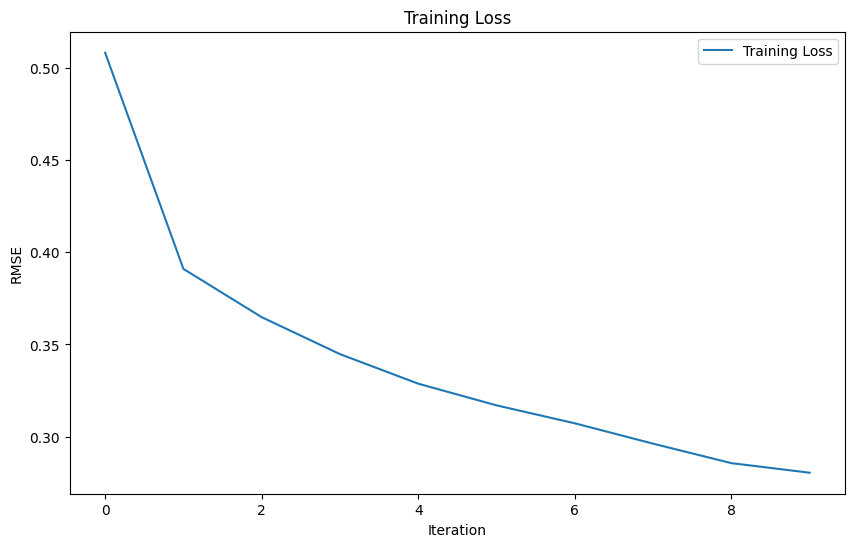

In [227]:
# plot trainng loss
plt.figure(figsize=(10, 6))
plt.plot(als.get_loss(), label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Loss')
plt.legend()
plt.show()

In [3]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-1m')

# Split the dataset into train and test
trainset, testset = train_test_split(data, test_size=.25)

# Use k-NN algorithm
algo = KNNBasic()

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9254


0.9254039704112041

# ALS with PySpark

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Create a Spark session
spark = SparkSession.builder.appName('recommender').getOrCreate()

# Load the data
data = spark.read.csv('data/ratings.csv', inferSchema=True, header=True)

# Split the data
(training, test) = data.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=10, userCol='userId', itemCol='movieId', ratingCol='rating')

# perform grid search
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [50, 100, 150, 200]) \
    .addGrid(als.regParam, [.01, .05, .1]) \
    .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Build CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Fit ALS model to training data
model = cv.fit(training)

# Extract best model from the tuning exercise using ParamGridBuilder
best_model = model.bestModel

# Generate predictions and evaluate using RMSE
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)

# Print evaluation metrics and model parameters
print("RMSE = " + str(rmse))
print("**Best Model**")
print(" Rank:", best_model.rank)
print(" MaxIter:", best_model._java_obj.parent().getMaxIter())
print(" RegParam:", best_model._java_obj.parent().getRegParam())

# make top_n recommendations for a user
n = 10
user_id = 1
# get the user's movie ratings
user_ratings = data.filter(data['userId'] == user_id)  
# get the movies the user has rated
rated_movies = user_ratings.select('movieId', 'userId')
# get the movies the user has not rated
unrated_movies = data.select('movieId').subtract(rated_movies)
# rename the column to userId
unrated_movies = unrated_movies.withColumn('userId', lit(int(user_id)))
# generate predictions
predictions = best_model.transform(unrated_movies)
# get the top n recommendations
top_n = predictions.orderBy('prediction', ascending=False).limit(n)
# get the movie titles
top_n_titles = top_n.join(movies, 'movieId', 'inner').select('title')
# show the recommendations
top_n_titles.show()

# Stop the Spark session
spark.stop()

SVD++ explicit

In [ ]:
import numpy as np

class SVDpp:
    def __init__(self, n_epochs=20, n_factors=10, lr=0.005, reg=0.02):
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg

    def fit(self, R):
        self.n_users, self.n_items = R.shape
        self.global_mean = np.mean(R[np.where(R != 0)])
        self.P = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.Q = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        self.Y = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        self.b_u = np.zeros(self.n_users)
        self.b_i = np.zeros(self.n_items)

        self.R = R

        for _ in range(self.n_epochs):
            for i in range(self.n_users):
                rated_items = np.where(R[i, :] != 0)[0]
                sqrt_n_ui = np.sqrt(len(rated_items))
                for j in rated_items:
                    err = R[i, j] - self.predict(i, j)
                    self.b_u[i] += self.lr * (err - self.reg * self.b_u[i])
                    self.b_i[j] += self.lr * (err - self.reg * self.b_i[j])
                    self.P[i, :] += self.lr * (err * self.Q[j, :] - self.reg * self.P[i,:])
                    self.Q[j, :] += self.lr * (err * (self.P[i, :] + (sqrt_n_ui * self.Y[rated_items, :].sum(axis=0))) - self.reg * self.Q[j,:])
                    self.Y[j, :] += self.lr * (err * self.Q[j, :] / sqrt_n_ui - self.reg * self.Y[j,:])

    def predict(self, i, j):
        if self.R[i, j] > 0:
            rated_items = np.where(self.R[i, :] != 0)[0]
            sqrt_n_ui = np.sqrt(len(rated_items))
            return self.global_mean + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :] + sqrt_n_ui * self.Y[rated_items, :].sum(axis=0), self.Q[j, :])
        return self.global_mean + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :], self.Q[j, :])

# Assume R is your ratings matrix
R = np.array([[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]])
model = SVDpp()
model.fit(R)
print(model.predict(0, 2))  # Predict the rating of user 0 for item 2

In [9]:
# ALS explicit
import numpy as np

class ALS:
    def __init__(self, n_factors=10, n_iterations=20, reg=0.01):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.reg = reg

    def fit(self, R):
        self.n_users, self.n_items = R.shape
        self.user_factors = np.random.random((self.n_users, self.n_factors))
        self.item_factors = np.random.random((self.n_items, self.n_factors))

        for _ in range(self.n_iterations):
            for u in range(self.n_users):
                self.user_factors[u] = self.solve(R[u, :], self.item_factors, self.reg, self.n_factors)
            for i in range(self.n_items):
                self.item_factors[i] = self.solve(R[:, i], self.user_factors, self.reg, self.n_factors)

    def solve(self, v, U, reg, n_factors):
        A = np.dot(U.T, U) + np.eye(n_factors) * reg
        b = np.dot(U.T, v)
        return np.linalg.solve(A, b)

    def predict(self):
        return self.user_factors.dot(self.item_factors.T)

# Assume R is your ratings matrix
R = np.array([[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]])
model = ALS()
model.fit(R)
print(np.round(model.predict(), decimals=2))  # Predict the entire matrix

[[ 5.    2.99 -0.    1.  ]
 [ 4.    0.   -0.    1.  ]
 [ 1.    1.    0.    5.  ]
 [ 1.    0.    0.    4.  ]
 [-0.01  1.    4.99  3.99]]
